In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import collections
import uuid
import itertools
import json
from frgpascal.experimentaldesign.recipes import SolutionRecipe, SpincoatRecipe, AnnealRecipe, Sample, from_json
from frgpascal.experimentaldesign.helpers import components_to_name
from frgpascal.hardware.sampletray import SampleTray
from frgpascal.hardware.liquidlabware import LiquidLabware
from copy import deepcopy

# Helper Functions

In [49]:
def generate_unique_id():
    return str(uuid.uuid4())

# Placeholder Workflow

In [50]:
def build_sample_list(available_trays, input_substrates, target_solutions, spincoat_recipes, anneal_recipes, n_repeats=1, ignore_storage = False):
    """
    Permutes experimental mesh into sample list
    """
    sample_list = []
    for tray in available_trays:
        tray.unload_all()
    trays = iter(available_trays)
    current_tray = next(trays)

    def get_storage_slot(name, current_tray, trays):
        loaded = False
        while not loaded:
            try:
                slot = current_tray.load(name)
                loaded = True
            except:
                try:
                    current_tray = next(trays)
                except StopIteration:
                    raise StopIteration('No more slots available in your storage trays!')
        return {
            'tray': current_tray.name,
            'slot': slot
        }, current_tray, trays
    
    for idx, (sub, sol, sc, an) in enumerate(itertools.product(input_substrates, target_solutions, spincoat_recipes, anneal_recipes)):
        # recipe_id = generate_unique_id()
        sc_ = deepcopy(sc)
        sc_.solution = sol
        
        for r in range(n_repeats):
            name = f'sample{idx}'
            if ignore_storage:
                storage_slot = None
            else:
                storage_slot, current_tray, trays = get_storage_slot(name, current_tray, trays)
            sample_list.append(Sample(
                name=name,
                substrate=sub,
                spincoat_recipe=sc_,
                anneal_recipe=an,
                storage_slot=storage_slot
                # sampleid=sampleid
            ))
            
    return sample_list

In [51]:
def suggest_stock_solutions(target_solutions):
    """
    suggests smallest number of stock solutions required to cover the
    target solution space
    """
    
    return stock_solutions

In [52]:
from scipy.optimize import nnls

def calculate_mix(target: SolutionRecipe, volume: float, stock_solutions: list, tolerance:float =0.05):
    """
    given a target solution, target volume, and list of stock solutions, calculates
    the volumes needed from individual stocks to achieve target composition

    tolerance (float): maximum error for single site (relative, not absolute) allowed.
    
    """        
    # get possible solution components from stock list
    components = set()
    for s in stock_solutions:
        components.update(s.solute_dict.keys(), s.solvent_dict.keys())
    components = list(components) #sets are not order-preserving, lists are - just safer this way

    # organize components into a stock matrix, keep track of which rows are solvents
    stock_matrix = np.zeros((len(components), len(stock_solutions)))
    solvent_idx = set()
    for n, s in enumerate(stock_solutions):
        for m, c in enumerate(components):
            if c in s.solute_dict: 
                stock_matrix[m,n] = s.solute_dict[c]*s.molarity
            elif c in s.solvent_dict:
                stock_matrix[m,n] = s.solvent_dict[c]
                solvent_idx.add(m)
    solvent_idx = list(solvent_idx)

    # organize target solution into a matrix of total mols desired of each component 
    target_matrix = np.zeros((len(components),))
    for m, c in enumerate(components):
        if c in target.solute_dict: 
            target_matrix[m] = target.solute_dict[c]*target.molarity*volume
        elif c in target.solvent_dict:
            target_matrix[m] = target.solvent_dict[c]*volume

    # solve for the mixture amounts
    amount_matrix, *data = nnls(stock_matrix, target_matrix, maxiter=1e3) #volumes to mix. math is better if not such small values in matrix, so scale to uL for calculation
    amount_matrix[amount_matrix < 1] = 0 #clean up values that are essentially 0. If we have a significant negative value here, should get caught downstream
    amount_matrix = np.round(amount_matrix) #round to nearest uL (values are in L at this point)

    # double check that the solved amounts make sense
    doublecheck = stock_matrix @ amount_matrix
    doublecheck[solvent_idx] /= doublecheck[solvent_idx].sum() / volume #solvents should sum to one
    # print(stock_matrix)
    # print(amount_matrix)
    # print(target_matrix)
    composition_error = max([np.abs(1-c/t) for c,t in zip(doublecheck, target_matrix) if t>0]) #max single-component error fraction

    if composition_error < 0.05: #check that we are within 5% error wrt target composition AT EACH SITE
        return amount_matrix
    else:
        solute = components_to_name({c:amt/target.molarity/volume for c,amt in zip(components, doublecheck) if amt > 0 and c not in target.solvent_dict})
        solvent = components_to_name({c:amt/target.molarity/volume for c,amt in zip(components, doublecheck) if amt > 0 and c in target.solvent_dict})
        # print(solvent)
        raise Exception(f'Unable to generate target solution ({volume} uL of {target}) with current stock solutions.\n\n'\
                        f'Closest match ({volume} uL of {target.molarity}M {solute} in {solvent}) has a max site error of {composition_error*100:.2f}%')#{Off by {composition_error*100:.2f}%%')

In [53]:
def build_solution_library(sample_list, stock_solutions):
    """
    finds volume required for each unique solution
    assigns a (labware, well) per solution
    generates a mixing netlist for liquid handler to convert stocks to mixed solutions
    """
    return solution_map, lh_netlist

In [54]:
def finalize_sample_list(sample_list, solution_map):
    """
    assigns the storage slots (tray, slot) and solution sources (labware, well)
    to each sample.
    """
    return final_sample_list, tray_list

## Generate Example Recipes

In [197]:
available_trays = [
    SampleTray(
        name='Tray1',
        version='storage_v1',
        gantry=None,
        gripper=None,
        p0=[0,0,0]
    ),
    SampleTray(
        name='Tray2',
        version='storage_v1',
        gantry=None,
        gripper=None,
        p0=[0,0,0]
    )
]

In [198]:
input_substrates = [
    '1mm_FTO'
]

In [199]:
target_solutions = [
    SolutionRecipe(
        solutes='MA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
    SolutionRecipe(
        solutes='FA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
    SolutionRecipe(
        solutes='FA0.25_MA0.75_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
    SolutionRecipe(
        solutes='FA0.75_MA0.25_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
    SolutionRecipe(
        solutes='MA0.5_FA0.5_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
]

In [200]:
cb_antisolvent = SolutionRecipe(
            solutes='',
            solvent='Chlorobenzene',
            molarity=1
        )
ma_antisolvent = SolutionRecipe(
            solutes='',
            solvent='MethylAcetate',
            molarity=1
        )


In [230]:
spincoat_recipes = [
    SpincoatRecipe(
        steps=[
            [500,1000,20], #speed (rpm), acceleration (rpm/s), duration (s)
            [4000,4000,30]
        ],
        solution_volume=100, #uL
        solution_droptime=-5, #seconds relative to start time
        antisolvent=cb_antisolvent,
        antisolvent_volume=50, #seconds relative to start time
        antisolvent_droptime=40,
    ),
    SpincoatRecipe(
        steps=[
            [500,1000,20],
            [4000,4000,30]
        ],
        solution_volume=100, #uL
        solution_droptime=-5,
        antisolvent=cb_antisolvent,
        antisolvent_volume=50,
        antisolvent_droptime=45,
    ),
]


In [231]:
anneal_recipes = [
    AnnealRecipe(
        temperature=100, #degrees C
        duration=60*60, #seconds
    ),
    AnnealRecipe(
        temperature=120, #degrees C
        duration=60*40, #seconds
    ),
    AnnealRecipe(
        temperature=140, #degrees C
        duration=60*20, #seconds
    ),
]

In [232]:
samples = build_sample_list(
    available_trays = available_trays,
    input_substrates = input_substrates,
    target_solutions = target_solutions,
    spincoat_recipes=spincoat_recipes,
    anneal_recipes=anneal_recipes,
    n_repeats=2
)
unique_solutions = list(set(
    [s.spincoat_recipe.solution for s in samples]
    + [s.spincoat_recipe.antisolvent for s in samples]))

print(f'{len(unique_solutions)} unique solutions required across {len(samples)} planned samples')

6 unique solutions required across 60 planned samples


## Define Stock Solutions

In [233]:
stock_solutions = [
    SolutionRecipe(
        solutes='MA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
    SolutionRecipe(
        solutes='FA_Pb_I3',
        solvent='DMF9_DMSO1',
        molarity=1
    ),
    SolutionRecipe(
        solutes='',
        solvent='DMF',
        molarity=1
    ),
    SolutionRecipe(
        solutes='',
        solvent='DMSO',
        molarity=1
    ),
    SolutionRecipe(
        solutes='',
        solvent='Chlorobenzene',
        molarity=1
    ),
    SolutionRecipe(
        solutes='',
        solvent='MethylAcetate',
        molarity=1
    ),
]

Can we cover target solutions with these stocks? and if so, how much of each stock to mix for each target?

In [234]:
min_volume = 0
solution_details = {s:dict(volume=min_volume, labware=None, slot=None) for s in unique_solutions}
for s in samples:
    for sol in [s.spincoat_recipe.solution, s.spincoat_recipe.antisolvent]:
        if sol is not None:
            solution_details[sol]['volume'] += s.spincoat_recipe.solution_volume
    

In [235]:
mixtures = np.array([
    calculate_mix(
        target=solution,
        volume=v['volume'],
        stock_solutions = stock_solutions
    ) for solution, v in solution_details.items()])

In [236]:
volumes_needed_per_stock = mixtures.sum(axis=0)
for s, v in zip(stock_solutions, volumes_needed_per_stock):
    if v > 0:
        print(f'{v/1e3} mL of {s}')

3.0 mL of <SolutionRecipe> 1M MA_Pb_I3 in DMF9_DMSO1
3.0 mL of <SolutionRecipe> 1M FA_Pb_I3 in DMF9_DMSO1
6.0 mL of <SolutionRecipe> Chlorobenzene


Which solutions need to be made from stocks?

In [237]:
to_be_mixed = {s:v for s,v in solution_details.items() if s not in stock_solutions}

What vessel do we need to put everything in? depends on required volumes

In [238]:
solution_storage = [
    LiquidLabware(
        name='96_Plate1',
        version='greiner_96_wellplate_360ul'
    ),
    LiquidLabware(
        name='96_Plate2',
        version='greiner_96_wellplate_360ul'
    ),
    LiquidLabware(
        name='4mL_Tray1',
        version='frg_28_wellplate_4000ul'
    ),

    LiquidLabware(
        name='4mL_Tray2',
        version='frg_28_wellplate_4000ul'
    ),
    LiquidLabware(
        name='15mL_Tray1',
        version='frg_12_wellplate_15000ul'   
    ),
    LiquidLabware(
        name='15m_Tray2',
        version='frg_12_wellplate_15000ul'
    ),
]

#sort by volume,name
solution_storage.sort(key=lambda labware: labware.name)
solution_storage.sort(key=lambda labware: labware.volume)
print('Priority Fill Order:')
for ss in solution_storage: print(ss)

Priority Fill Order:
<LiquidLabware> 96_Plate1, 0.36 mL volume, 96 wells
<LiquidLabware> 96_Plate2, 0.36 mL volume, 96 wells
<LiquidLabware> 4mL_Tray1, 4.0 mL volume, 28 wells
<LiquidLabware> 4mL_Tray2, 4.0 mL volume, 28 wells
<LiquidLabware> 15mL_Tray1, 15.0 mL volume, 12 wells
<LiquidLabware> 15m_Tray2, 15.0 mL volume, 12 wells


In [239]:
def where_to_store(volume, options):
    for ll in options:
        if volume <= ll.volume and len(ll._openslots) > 0:
            return ll
    raise ValueError(f'No options have enough space to hold {volume/1e3:.2f} mL!')



In [240]:
for solution, v in solution_details.items():
    ll = where_to_store(v['volume'], solution_storage) #which liquid labware
    slot = ll.load(solution)
    solution_details[solution]['labware'] = ll.name
    solution_details[solution]['slot'] = slot

In [241]:
solution_details

{<SolutionRecipe> Chlorobenzene: {'volume': 6000,
  'labware': '15mL_Tray1',
  'slot': 'A1'},
 <SolutionRecipe> 1M FA0.75_MA0.25_Pb_I3 in DMF9_DMSO1: {'volume': 1200,
  'labware': '4mL_Tray1',
  'slot': 'A1'},
 <SolutionRecipe> 1M MA_Pb_I3 in DMF9_DMSO1: {'volume': 1200,
  'labware': '4mL_Tray1',
  'slot': 'A2'},
 <SolutionRecipe> 1M FA0.25_MA0.75_Pb_I3 in DMF9_DMSO1: {'volume': 1200,
  'labware': '4mL_Tray1',
  'slot': 'A3'},
 <SolutionRecipe> 1M FA_Pb_I3 in DMF9_DMSO1: {'volume': 1200,
  'labware': '4mL_Tray1',
  'slot': 'A4'},
 <SolutionRecipe> 1M MA0.5_FA0.5_Pb_I3 in DMF9_DMSO1: {'volume': 1200,
  'labware': '4mL_Tray1',
  'slot': 'A5'}}

Set up the mixing netlist for liquid handler

In [242]:
mixing_netlist = {} #destination: {source, volume}

for target, target_v in solution_details.items():
    if target in stock_solutions:
        continue #stock solution is already made
    destination = f"{target_v['labware']}-{target_v['slot']}"
    mixing_netlist[destination] = {}
    required_volumes = calculate_mix(
        target=target,
        volume=target_v['volume'],
        stock_solutions = stock_solutions
    )
    for stock, vol in zip(stock_solutions, required_volumes):
        if vol > 0:    
            stock_v = solution_details[stock]
            source = f"{stock_v['labware']}-{stock_v['slot']}"
            mixing_netlist[destination][source]=vol
            


Set up the sample instructions using specific labware/slots

In [243]:
class Worker:
    def __init__(self, name, capacity):
        self.name = name
        self.capacity = capacity

    def __repr__(self):
        return f'<Worker> {self.name}'

In [244]:
gg = Worker(name='gantry_gripper', capacity=1)
sclh = Worker(name='spincoater_liquidhander', capacity=1)
hp = Worker(name='hotplate', capacity=25)
st = Worker(name='storage', capacity=45)
cl = Worker(name='characterizationline', capacity=1)

workers = [gg,sclh,hp,st,cl]
workers

[<Worker> gantry_gripper,
 <Worker> spincoater_liquidhander,
 <Worker> hotplate,
 <Worker> storage,
 <Worker> characterizationline]

In [245]:
class Task:
    def __init__(self, sample, task, workers, duration, task_details = '', precedents=[], reservoir=[]):
        self.sample=sample
        self.workers = workers
        self.task = task
        self.task_details = task_details
        self.taskid = f'{task}-{str(uuid.uuid4())}'
        self.precedents = precedents
        self.reservoir=[]
        if sum([immediate for task, immediate in precedents]) > 1:
            raise ValueError('Only one precedent can be immediate!')
        self.duration = int(duration)


    def __repr__(self):
        return f'<Task> {self.sample.name}, {self.task}'

    def __eq__(self, other):
        return other==self.taskid


class StorageToSpincoater(Task):
    def __init__(self, sample, precedents=[], start_time = 0):
        super().__init__(
            sample=sample,
            task='storage_to_spincoater',
            workers=[gg, sclh],
            duration=30,
            precedents = precedents,
            reservoir = [
                (sclh, 1)
            ]
            )
class Spincoat(Task):
    def __init__(self, sample, recipe:SpincoatRecipe, precedents=[], start_time = 0):
        super().__init__(
            sample=sample,
            task='spincoat',
            workers=[sclh],
            duration=recipe.duration + 45,
            task_details=recipe.to_json(),
            precedents = precedents,
            )
class SpincoaterToHotplate(Task):
    def __init__(self, sample, precedents=[], start_time = 0):
        super().__init__(
            sample=sample,
            task='spincoater_to_hotplate',
            workers=[gg, sclh],
            duration= 30,
            precedents = precedents,
            reservoir = [
                (sclh, -1)
            ]
            )
class Anneal(Task):
    def __init__(self, sample, recipe:AnnealRecipe, precedents=[], start_time = 0):
        super().__init__(
            sample=sample,
            task='anneal',
            workers=[hp],
            duration=recipe.duration,
            task_details=recipe.to_json(),
            precedents = precedents,
            )
class HotplateToStorage(Task):
    def __init__(self, sample, precedents=[], start_time = 0):
        super().__init__(
            sample=sample,
            task='hotplate_to_storage',
            workers=[gg],
            duration= 30,
            precedents = precedents,
            )
class Cooldown(Task):
    def __init__(self, sample, precedents=[], start_time = 0):
        super().__init__(
            sample=sample,
            task='cooldown',
            workers=[st],
            duration= 180,
            precedents = precedents,
            )
class StorageToCharacterization(Task):
    def __init__(self, sample, precedents=[], start_time = 0):
        super().__init__(
            sample=sample,
            task='storage_to_characterization',
            workers=[gg, cl],
            duration= 30,
            precedents = precedents,
            reservoir = [
                (cl, 1)
            ]
            )
class Characterize(Task):
    def __init__(self, sample, precedents=[], start_time = 0):
        super().__init__(
            sample=sample,
            task='characterize',
            workers=[cl],
            duration= 120,
            precedents = precedents,
            )
class CharacterizationToStorage(Task):
    def __init__(self, sample, precedents=[], start_time = 0):
        super().__init__(
            sample=sample,
            task='characterization_to_storage',
            workers=[gg, cl],
            duration= 30,
            precedents = precedents,
            reservoir = [
                (cl, -1)
            ]
            )

In [246]:
def generate_tasks_for_sample(sample: Sample, start_time = 0):
    tasks = []
    tasks.append(StorageToSpincoater(
        sample=sample,
        precedents=[]))
    tasks.append(Spincoat(
        sample=sample, 
        recipe=sample.spincoat_recipe, 
        precedents=[
            (tasks[-1], False) #(task, (bool)immediate)
        ]))
    tasks.append(SpincoaterToHotplate(
        sample=sample,
        precedents=[
            (tasks[-1], True)
        ]))
    tasks.append(Anneal(
        sample=sample,
        recipe = sample.anneal_recipe,
        precedents=[
            (tasks[-1], True)
        ]))    
    tasks.append(HotplateToStorage(
        sample=sample, 
        precedents=[
            (tasks[-1], True)
        ]))    
    tasks.append(Cooldown(
        sample=sample,
        precedents=[
                (tasks[-1], True)
            ]))    
    tasks.append(StorageToCharacterization(
        sample=sample,
        precedents=[
            (tasks[-1], False)
        ]))    
    tasks.append(Characterize(
        sample=sample,
        precedents=[
            (tasks[-1], False)
        ]))    
    tasks.append(CharacterizationToStorage(
        sample=sample,
        precedents=[
            (tasks[-1], False)
        ]))    
    return tasks

In [247]:
tasks = collections.OrderedDict({s:generate_tasks_for_sample(s) for s in samples})

In [248]:
from ortools.sat.python import cp_model

class Scheduler:
    def __init__(self, workers, tasks, spanning_tasks = []):
        self.workers = workers
        self.tasks = tasks
        self.tasklist = [t
            for sample_tasks in tasks.values()
            for t in sample_tasks]
        self.horizon = int(sum([
            t.duration for t in self.tasklist]))
        self.spanning_tasks = spanning_tasks
        self.initialize_model()

    def initialize_model(self):
        self.model = cp_model.CpModel()
        ending_variables = []
        machine_intervals = {w:[] for w in self.workers}
        reservoirs = {}
        ### Task Constraints
        for task in self.tasklist:
            task.end_var = self.model.NewIntVar(task.duration, self.horizon, "end"+str(task))
            ending_variables.append(task.end_var)

        for task in self.tasklist:
            ## connect to preceding tasks
            immediate_precedent = [precedent for precedent, immediate in task.precedents if immediate] #list of immediate precedents  
            if len(immediate_precedent) == 0:
                task.start_var = self.model.NewIntVar(0, self.horizon, "start"+str(task))
            else:
                precedent = immediate_precedent[0]
                task.start_var = precedent.end_var

            for precedent, immediate in task.precedents:
                if not immediate:
                    self.model.Add(task.start_var >= precedent.end_var)
            
            ## mark workers as occupied during this task
            interval_var = self.model.NewIntervalVar(task.start_var, task.duration, task.end_var, "interval"+str(task))
            for w in task.workers:
                machine_intervals[w].append(interval_var)
        
        ### Force sequential tasks to preserve order even if not immediate
        spanning_tasks = {c:[] for c in self.spanning_tasks} 
        for sample, tasks in self.tasks.items():
            for start_class, end_class in spanning_tasks:
                start_var = [t for t in tasks if t.__class__ == start_class][0].start_var
                end_var = [t for t in tasks if t.__class__ == end_class][0].end_var

                duration = self.model.NewIntVar(0, self.horizon, 'duration')
                interval = self.model.NewIntervalVar(start_var, duration, end_var, 'sampleinterval')
                spanning_tasks[(start_class, end_class)].append(interval)
        for intervals in spanning_tasks.values():
            self.model.AddNoOverlap(intervals)

        ### Worker Constraints
        for w in workers:
            intervals = machine_intervals[w]
            if w.capacity > 1:
                demands = [1 for _ in machine_intervals[w]]
                self.model.AddCumulative(intervals, demands, w.capacity)
            else:
                self.model.AddNoOverlap(intervals)
        for w, r in reservoirs.items():
            self.modelAddReservoirConstraint(r['times'], r['demands'], 0, w.capacity)
        objective_var = self.model.NewIntVar(0,self.horizon, 'makespan')
        self.model.AddMaxEquality(objective_var, ending_variables)
        self.model.Minimize(objective_var)

    def solve(self, solve_time = 5):
        self.solver = cp_model.CpSolver()
        self.solver.parameters.max_time_in_seconds = solve_time
        status = self.solver.Solve(self.model)

    # def _set_start_time(self, task):
    #     for pid in task.precedents:
    #         ptidx = self.tasks.index(pid)
    #         pt = self.tasks[ptidx]
    #         if pt.end_time < task.start_time:
    #             task.start_time = pt.end_time



In [249]:
scheduler = Scheduler(
    workers=workers,
    tasks=tasks,
    spanning_tasks = [
        (StorageToSpincoater, SpincoaterToHotplate),
        (StorageToCharacterization, CharacterizationToStorage),
    ] #these tasks spanning each pair must be done in sequence per sample
)

In [250]:
scheduler.solve(5)

Text(0.5, 0, 'Time (minutes)')

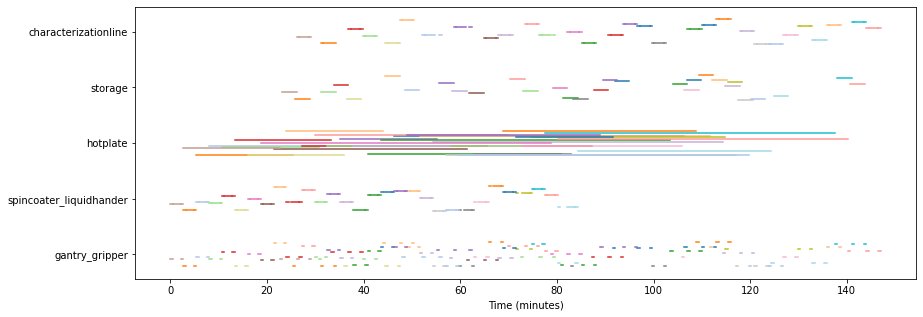

In [251]:
plt.figure(figsize=(14,5))

for idx, (sample, tasklist) in enumerate(scheduler.tasks.items()):
    color = plt.cm.tab20(idx%20)
    offset = np.random.random()*0.5 - 0.25
    for t in tasklist:
        for w in t.workers:
            y = [scheduler.workers.index(w) + offset]*2
            x = [scheduler.solver.Value(t.start_var)/60, scheduler.solver.Value(t.end_var)/60]
            plt.plot(x,y, color=color)

plt.yticks(range(len(scheduler.workers)), labels=[w.name for w in scheduler.workers])
plt.xlabel('Time (minutes)')
# plt.xlim(left=0)
# plt.xlim(70,100)
        

In [96]:
ordered_tasks = []
ott = collections.namedtuple('orderedtask', 'start sample task')
for sample, tasklist in scheduler.tasks.items():
    for task in tasklist:
        start_time = scheduler.solver.Value(task._start)
        ordered_tasks.append(ott(start_time, sample, task))
ordered_tasks.sort(key=lambda x:x.start)

In [100]:
for t in ordered_tasks:
    print(f'{t.start}, {t.task}')

0, <Task> sample0, storage_to_spincoater
30, <Task> sample0, spincoat
130, <Task> sample0, spincoater_to_hotplate
160, <Task> sample0, anneal
160, <Task> sample1, storage_to_spincoater
190, <Task> sample1, spincoat
290, <Task> sample1, spincoater_to_hotplate
320, <Task> sample1, anneal
320, <Task> sample2, storage_to_spincoater
350, <Task> sample2, spincoat
450, <Task> sample2, spincoater_to_hotplate
480, <Task> sample2, anneal
480, <Task> sample3, storage_to_spincoater
510, <Task> sample3, spincoat
610, <Task> sample3, spincoater_to_hotplate
640, <Task> sample3, anneal
780, <Task> sample4, storage_to_spincoater
810, <Task> sample4, spincoat
910, <Task> sample4, spincoater_to_hotplate
940, <Task> sample4, anneal
980, <Task> sample6, storage_to_spincoater
1010, <Task> sample6, spincoat
1080, <Task> sample2, hotplate_to_storage
1110, <Task> sample2, cooldown
1110, <Task> sample6, spincoater_to_hotplate
1140, <Task> sample6, anneal
1220, <Task> sample9, storage_to_spincoater
1250, <Task> 

# Write final files to disk

## Write mixing netlist to disk, will be copy-pasted into listener.py protocol

In [24]:
with open('netlist.json', 'w') as f:
    json.dump(mixing_netlist, f)
print('Liquid Handler Netlist String dumped to "netlist.json"')

Liquid Handler Netlist String dumped to "netlist.json"
